### Раздел 1. Задача

Для каждого пользователя требуется предоставить 3 наиболее релевантных товара из отранжированного списка.

К задаче приложены четыре файла: **train.csv**, **test.csv**, **items.csv**, **scoring.csv**  
#### **train.csv** - содержит исторические покупки 10 тысяч пользователей:  
&emsp;**user_id** - идентификатор пользователя  
&emsp;**event_ts_train** - дата покупки  
&emsp;**item_id** - идентификатор товара  
#### **test.csv** - структура аналогична файлу train. В файле содержится одна **следующая** покупка гостя, длиной ровно 3 продукта  
#### **items.csv** - справочник товаров  
&emsp;**item_id** - идентификатор товара  
&emsp;**feature_1** - категориальный признак товара  
&emsp;**feature_2** - категориальный признак товара  
&emsp;**feature_3** - вещественный признак товара  
#### **scoring.csv** - файл для скоринга, структура аналогична файлу test и train.

### Понимание задачи

Задача персональных рекомендаций: обучить алгоритм на исторических покупках из **train.csv**, протестировать на последних покупках из **test.csv**, затем предсказать топ-3 товара для каждого пользователя в **scoring.csv**. Основная Метрика качества — **precision@3** (доля релевантных товаров среди топ-3 рекомендаций).

In [411]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use('seaborn-v0_8')


Загружаю исходные таблицы: train для обучения, test для проверки, scoring для финального предсказания и items как справочник признаков. 

In [412]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
items_df = pd.read_csv('items.csv')
scoring_df = pd.read_csv('scoring.csv')

print("Размеры датасетов:")
print(f"train: {train_df.shape}")
print(f"test: {test_df.shape}")
print(f"items: {items_df.shape}")
print(f"scoring: {scoring_df.shape}")


Размеры датасетов:
train: (315453, 3)
test: (30000, 3)
items: (57, 4)
scoring: (30000, 3)


Проверяю базовую схему данных: какие колонки есть в каждом файле и соответствуют ли они ожидаемым. 

In [413]:
scoring_df.dtypes, test_df.dtypes, train_df.dtypes, items_df.dtypes

(user_id          int64
 event_ts_val    object
 item_id          int64
 dtype: object,
 user_id           int64
 event_ts_test    object
 item_id           int64
 dtype: object,
 user_id            int64
 event_ts_train    object
 item_id            int64
 dtype: object,
 item_id      int64
 feature_1    int64
 feature_2    int64
 feature_3    int64
 dtype: object)

Временные диапазоны показывают, что train, test и scoring не пересекаются по времени: train заканчивается 22 июля, test начинается 23 июля и заканчивается 30 сентября, scoring начинается 1 октября.

In [414]:
# парсю даты в datetime и вывожу диапазоны
train_df['event_ts_train'] = pd.to_datetime(train_df['event_ts_train'])
test_df['event_ts_test'] = pd.to_datetime(test_df['event_ts_test'])
scoring_df['event_ts_val'] = pd.to_datetime(scoring_df['event_ts_val'])

print("Диапазоны дат:")
print(f"train: {train_df['event_ts_train'].min()} и {train_df['event_ts_train'].max()}")
print(f"test: {test_df['event_ts_test'].min()} и {test_df['event_ts_test'].max()}")
print(f"scoring: {scoring_df['event_ts_val'].min()} и {scoring_df['event_ts_val'].max()}")


Диапазоны дат:
train: 2024-04-20 00:00:00 и 2024-07-22 00:00:00
test: 2024-07-23 00:00:00 и 2024-09-30 00:00:00
scoring: 2024-10-01 00:00:00 и 2024-12-23 00:00:00


In [415]:
# проверяю пропуски в каждом датасете
for name, df in [("train", train_df), ("test", test_df), ("items", items_df), ("scoring", scoring_df)]:
    print(f"{name}:")
    print(df.isna().sum())
    print()

#в ключевых полях нет пропусков
assert train_df[['user_id', 'item_id']].isna().sum().sum() == 0, "В train есть пропуски в user_id или item_id"
assert test_df[['user_id', 'item_id']].isna().sum().sum() == 0, "В test есть пропуски в user_id или item_id"
assert items_df['item_id'].isna().sum() == 0, "В items есть пропуски в item_id"
assert scoring_df['user_id'].isna().sum() == 0, "В scoring есть пропуски в user_id"


train:
user_id           0
event_ts_train    0
item_id           0
dtype: int64

test:
user_id          0
event_ts_test    0
item_id          0
dtype: int64

items:
item_id      0
feature_1    0
feature_2    0
feature_3    0
dtype: int64

scoring:
user_id         0
event_ts_val    0
item_id         0
dtype: int64



### Дубликаты в данных

в `train` есть дубликаты строк (одинаковые `user_id`, `item_id`, `event_ts_train`). это можно трактовать как повторы покупок или особенности логирования. на этом этапе я **не удаляю** дубликаты, потому что они могут быть полезным сигналом **counts** (частота взаимодействий). если понадобится бинарный сигнал "покупал/не покупал", матрицу можно будет отдельно бинаризовать.

In [416]:
#полные дубликаты строк
for name, df in [("train", train_df), ("test", test_df), ("scoring", scoring_df)]:
    n_dups = df.duplicated().sum()
    print(f"{name}: {n_dups}")

train_key_dups = train_df.duplicated(subset=['user_id', 'item_id', 'event_ts_train']).sum()
print(f"train (по ключам): {train_key_dups}")


train: 7403
test: 0
scoring: 0
train (по ключам): 7403


Проверки формата: уникальность item_id в items, ровно 3 строки на пользователя в test, отсутствие холодного старта (все пользователи и товары из test есть в train).


In [417]:
# проверяю уникальность item_id в items
item_dups = items_df['item_id'].duplicated().sum()
print(f"items (дубликаты item_id): {item_dups}")
assert item_dups == 0, f"item_id в items не уникален: {item_dups} дубликатов"

items (дубликаты item_id): 0


In [418]:
# в test ровно 3 строки на пользователя
test_sizes = test_df.groupby('user_id').size()
print("Распределение числа строк на пользователя в test:")
print(test_sizes.describe())
print(f"\nМинимум: {test_sizes.min()}, максимум: {test_sizes.max()}")

Распределение числа строк на пользователя в test:
count    10000.0
mean         3.0
std          0.0
min          3.0
25%          3.0
50%          3.0
75%          3.0
max          3.0
dtype: float64

Минимум: 3, максимум: 3


In [419]:
# проверяю покрытие все пользователи и товары из test есть в train и items
train_users = set(train_df['user_id'].unique())
test_users = set(test_df['user_id'].unique())
train_items = set(train_df['item_id'].unique())
test_items = set(test_df['item_id'].unique())
items_catalog = set(items_df['item_id'].unique())

missing_users = test_users - train_users
missing_items_train = test_items - train_items
missing_items_catalog = test_items - items_catalog

print(f"test users missing in train: {len(missing_users)}")
print(f"test items missing in train: {len(missing_items_train)}")
print(f"test items missing in items: {len(missing_items_catalog)}")


test users missing in train: 0
test items missing in train: 0
test items missing in items: 0


### Раздел 2. Проверка таблиц и приведение к форматам

Загружаю все файлы данных и выполняю базовые проверки целостности: размеры таблиц, типы данных, пропуски, дубликаты и валидацию формата, чтобы убедиться, что данные читаются корректно и нет проблем, которые сломают последующие этапы анализа и моделирования.


In [420]:
#проверяю типы и привожу даты к datetime
train_df['event_ts_train'] = pd.to_datetime(train_df['event_ts_train'])
test_df['event_ts_test'] = pd.to_datetime(test_df['event_ts_test'])
scoring_df['event_ts_val'] = pd.to_datetime(scoring_df['event_ts_val'])


In [421]:
# сводим формы датасетов
for name, df in [
    ("train", train_df),
    ("test", test_df),
    ("items", items_df),
    ("scoring", scoring_df),
]:
    print(f"{name}: форма {df.shape}")


train: форма (315453, 3)
test: форма (30000, 3)
items: форма (57, 4)
scoring: форма (30000, 3)


Просматриваю первые строки каждого датасета, чтобы убедиться, что колонки читаются корректно и типы данных соответствуют ожиданиям.

In [422]:
#первые строки каждого датасета
for name, df in [("train", train_df), ("test", test_df), ("items", items_df), ("scoring", scoring_df)]:
    print(f"\n{name}:")
    display(df.head(3))


train:


,user_id,event_ts_train,item_id
0,0,2024-05-03,14
1,0,2024-05-05,6
2,0,2024-05-16,28



test:


,user_id,event_ts_test,item_id
0,0,2024-08-17,4
1,0,2024-08-17,19
2,0,2024-08-17,0



items:


,item_id,feature_1,feature_2,feature_3
0,0,0,0,1170
1,1,0,0,1138
2,2,1,0,1386



scoring:


,user_id,event_ts_val,item_id
0,0,2024-11-05,1
1,0,2024-11-05,3
2,0,2024-11-05,8


### Что такое scoring.csv и как я его использую

scoring.csv использую как шаблон для финального сабмита: для каждого user_id нужно вернуть **3 рекомендации** (top-3 item_id). Далее я генерирую рекомендации выбранной моделью и заполняю ими колонку item_id, проверяя формат (3 строки на пользователя, без nan и дублей).


In [423]:
# сводка по пропускам
missing_summary = []
for name, df in [("train", train_df), ("test", test_df), ("items", items_df), ("scoring", scoring_df)]:
    missing_summary.append(pd.DataFrame({"dataset": name, "column": df.columns, "missing": df.isna().sum().values}))
missing_summary = pd.concat(missing_summary, ignore_index=True)
missing_summary

,dataset,column,missing
0,train,user_id,0
1,train,event_ts_train,0
2,train,item_id,0
3,test,user_id,0
4,test,event_ts_test,0
5,test,item_id,0
6,items,item_id,0
7,items,feature_1,0
8,items,feature_2,0
9,items,feature_3,0


### Раздел 3. EDA и понимание данных

Цель EDA: понять разреженность данных, перекосы по пользователям и товарам, и что это значит для выбора моделей. Анализирую временные диапазоны, распределения активности пользователей, популярность товаров, разреженность user-item матрицы и повторные покупки.


Временные диапазоны и проверка отсутствия утечки

In [424]:
# проверяю временные диапазоны и отсутствие утечки данных
train_min, train_max = train_df['event_ts_train'].min(), train_df['event_ts_train'].max()
test_min, test_max = test_df['event_ts_test'].min(), test_df['event_ts_test'].max()
scoring_min, scoring_max = scoring_df['event_ts_val'].min(), scoring_df['event_ts_val'].max()

print("Временные диапазоны:")
print(f"train: {train_min} -> {train_max}")
print(f"test: {test_min} -> {test_max}")
print(f"scoring: {scoring_min} -> {scoring_max}")

assert train_max < test_min, f"Утечка данных: train_max ({train_max}) >= test_min ({test_min})"
assert test_max < scoring_min, f"Утечка данных: test_max ({test_max}) >= scoring_min ({scoring_min})"



Временные диапазоны:
train: 2024-04-20 00:00:00 -> 2024-07-22 00:00:00
test: 2024-07-23 00:00:00 -> 2024-09-30 00:00:00
scoring: 2024-10-01 00:00:00 -> 2024-12-23 00:00:00


Пользователи: сколько их в train и какая активность (распределение числа покупок на пользователя). 

In [425]:
# статистики по пользователям
n_users = train_df['user_id'].nunique()
print(f"Число пользователей в train: {n_users}")

user_purchase_counts = train_df.groupby('user_id').size()
print("\nРаспределение покупок на пользователя:")
print(user_purchase_counts.describe(percentiles=[0.25, 0.5, 0.75, 0.95]))


Число пользователей в train: 10000

Распределение покупок на пользователя:
count    10000.000000
mean        31.545300
std         26.285312
min          1.000000
25%         14.000000
50%         25.000000
75%         41.000000
95%         80.000000
max        381.000000
dtype: float64


In [426]:
print("\nКвантили:")
print(f"25%: {user_purchase_counts.quantile(0.25):.1f}")
print(f"50%: {user_purchase_counts.quantile(0.5):.1f}")
print(f"75%: {user_purchase_counts.quantile(0.75):.1f}")
print(f"95%: {user_purchase_counts.quantile(0.95):.1f}")


Квантили:
25%: 14.0
50%: 25.0
75%: 41.0
95%: 80.0


In [427]:
print("\nТоп-5 самых активных пользователей:")
top_users = user_purchase_counts.nlargest(5)
for uid, count in top_users.items():
    print(f"user_id {uid}: {count} покупок")


Топ-5 самых активных пользователей:
user_id 6614: 381 покупок
user_id 5621: 288 покупок
user_id 8330: 269 покупок
user_id 5883: 263 покупок
user_id 3858: 237 покупок


Распределение покупок на пользователя показывает сильный разброс активности: 

медиана составляет 25 покупок, но есть пользователи с 1 покупкой и пользователи с более чем 300 покупками. 

Половина пользователей совершает от 14 до 41 покупки, а 5% самых активных более 80 покупок. Такой разброс означает, что для пользователей с малой историей (менее 10–15 покупок) персональные рекомендации будут менее надёжными, и потребуется замещение на глобально популярные товары. 

Для активных пользователей с большим количеством покупок персональные модели (например, personal popular или item-based CF) могут работать значительно лучше, чем глобальный бейзлайн.


Товары: сколько товаров в каталоге и насколько выражены хиты (long-tail распределение), чтобы понимать силу бейзлайна global popular: если топ-10 товаров составляют большую долю покупок, то простой бейзлайн будет работать хорошо.


In [428]:
# статистики по товарам
n_items_train = train_df['item_id'].nunique()
n_items_catalog = items_df['item_id'].nunique()
print(f"товаров в train: {n_items_train}")
print(f"товаров в items: {n_items_catalog}")

purchases_per_item = train_df.groupby('item_id').size()
print("\nраспределение покупок на товар:")
print(purchases_per_item.describe(percentiles=[0.25, 0.5, 0.75, 0.95]))


товаров в train: 57
товаров в items: 57

распределение покупок на товар:
count       57.000000
mean      5534.263158
std       7795.424163
min        161.000000
25%        774.000000
50%       2304.000000
75%       7206.000000
95%      17664.600000
max      41918.000000
dtype: float64


In [429]:
print("\nквантили:")
print(f"  25%: {purchases_per_item.quantile(0.25):.1f}")
print(f"  50%: {purchases_per_item.quantile(0.5):.1f}")
print(f"  75%: {purchases_per_item.quantile(0.75):.1f}")
print(f"  95%: {purchases_per_item.quantile(0.95):.1f}")


квантили:
  25%: 774.0
  50%: 2304.0
  75%: 7206.0
  95%: 17664.6


In [430]:
print("\nтоп-10 товаров по популярности:")
top_items = purchases_per_item.nlargest(10)
for item_id, count in top_items.items():
    print(f"  item_id {item_id}: {count}")


топ-10 товаров по популярности:
  item_id 19: 41918
  item_id 1: 28216
  item_id 0: 26891
  item_id 6: 15358
  item_id 2: 14901
  item_id 8: 14313
  item_id 12: 12522
  item_id 3: 11964
  item_id 7: 11096
  item_id 14: 10870


Разреженность user-item матрицы: по уникальным парам (user, item) и по событиям (с учетом повторов), чтобы выбрать модели: высокая разреженность означает, что нужно использовать sparse матрицы, а также влияет на выбор алгоритма (например, item-based cf работает лучше при высокой разреженности).


In [431]:
# разреженность user-item матрицы
n_users = train_df['user_id'].nunique()
n_items = train_df['item_id'].nunique()
total_cells = n_users * n_items

unique_pairs = train_df[['user_id', 'item_id']].drop_duplicates().shape[0]
events = len(train_df)

density_unique = unique_pairs / total_cells
density_events = events / total_cells
sparsity_unique = 1 - density_unique

print(f"размер матрицы: {n_users} пользователей × {n_items} товаров = {total_cells:,} ячеек")
print(f"уникальных пар (user, item): {unique_pairs:,}")
print(f"всего событий (с повторами): {events:,}")
print(f"\nплотность уникальных пар: {density_unique:.4f} ({density_unique*100:.2f}%)")
print(f"плотность событий: {density_events:.4f} ({density_events*100:.2f}%)")
print(f"разреженность: {sparsity_unique:.4f} ({sparsity_unique*100:.2f}%)")


размер матрицы: 10000 пользователей × 57 товаров = 570,000 ячеек
уникальных пар (user, item): 109,751
всего событий (с повторами): 315,453

плотность уникальных пар: 0.1925 (19.25%)
плотность событий: 0.5534 (55.34%)
разреженность: 0.8075 (80.75%)


Высокая разреженность (81%) хорошие условия для item-based collaborative filtering.

Повторы покупок: есть ли повторяющиеся события и что это значит (counts vs binary)


In [432]:
# проверяю повторы покупок
user_item_counts = train_df.groupby(['user_id', 'item_id']).size()
repeated_pairs = (user_item_counts > 1).sum()
total_pairs = len(user_item_counts)
repeat_share = repeated_pairs / total_pairs

print(f"Пар (user_id, item_id), которые встречаются > 1 раза: {repeated_pairs:,} из {total_pairs:,}")
print(f"Доля повторных взаимодействий: {repeat_share:.1%}")


Пар (user_id, item_id), которые встречаются > 1 раза: 57,916 из 109,751
Доля повторных взаимодействий: 52.8%


Более 50% пар покупались более 1 раза - частота покупок важный сигнал.

График 1: daily trend по train (сколько покупок в день)


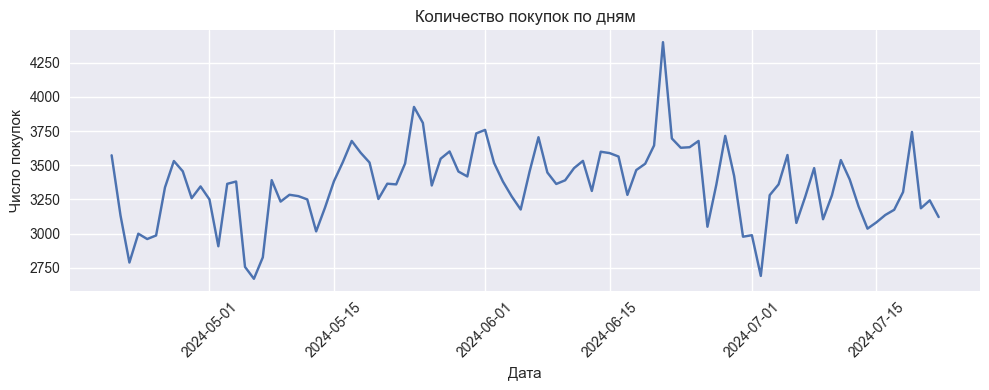

Статистика покупок по дням:
count      94.000000
mean     3355.882979
std       280.866779
min      2669.000000
25%      3192.750000
50%      3363.500000
75%      3531.750000
max      4401.000000
Name: item_id, dtype: float64


In [433]:
#динамику покупок по дням
train_df['date'] = train_df['event_ts_train'].dt.date
daily_purchases = train_df.groupby('date')['item_id'].count()

plt.figure(figsize=(10, 4))
daily_purchases.plot()
plt.title('Количество покупок по дням')
plt.xlabel('Дата')
plt.ylabel('Число покупок')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Статистика покупок по дням:")
print(daily_purchases.describe())


Стабильный тренд с небольшими колебаниями, без явных сезонных пиков.

График 2: user activity histogram (распределение числа покупок на пользователя)


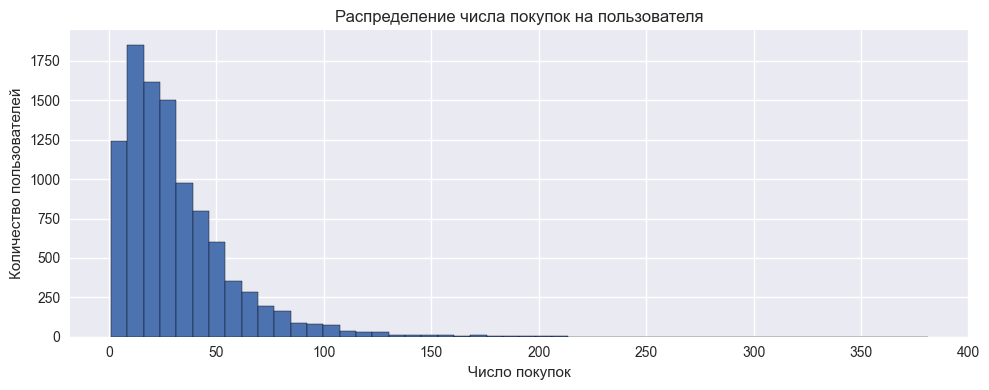

In [434]:
# user activity histogram
purchases_per_user = train_df.groupby('user_id').size()

plt.figure(figsize=(10, 4))
plt.hist(purchases_per_user.values, bins=50, edgecolor='black')
plt.title('Распределение числа покупок на пользователя')
plt.xlabel('Число покупок')
plt.ylabel('Количество пользователей')
plt.tight_layout()
plt.show()


Большинство пользователей совершает 10-60 покупок, но есть хвост очень активных пользователей.

График 3: item popularity / long-tail (top-20 барчарт)


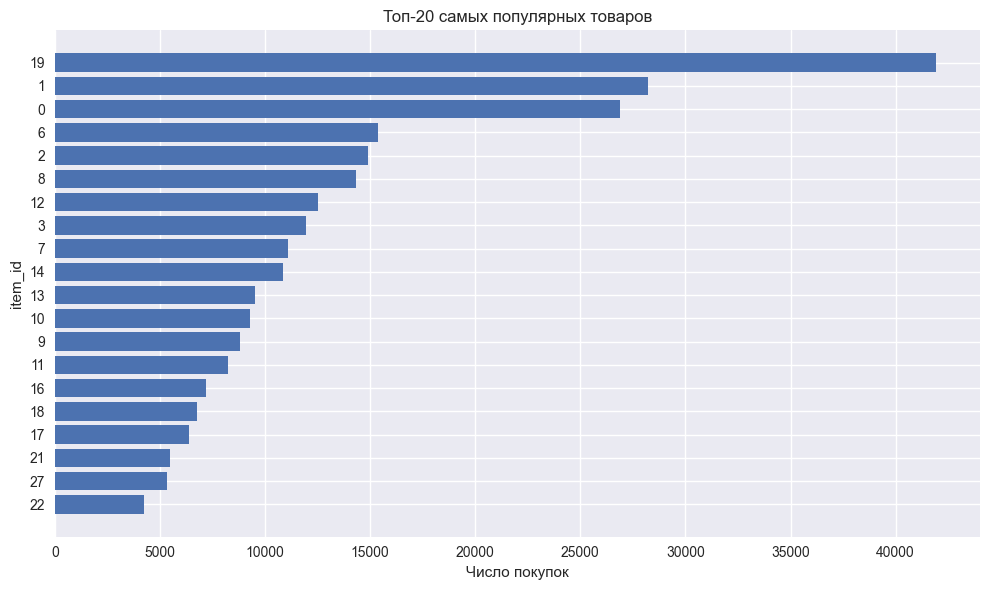

In [435]:
# item popularity (top-20)
purchases_per_item = train_df.groupby('item_id').size()
top_20_items = purchases_per_item.nlargest(20)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_20_items)), top_20_items.values)
plt.yticks(range(len(top_20_items)), top_20_items.index)
plt.title('Топ-20 самых популярных товаров')
plt.xlabel('Число покупок')
plt.ylabel('item_id')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**Итоговый вывод по EDA:**

Свойства данных для baseline'ов и подходов:

- топ-10 товаров составляют большую долю всех покупок, что простой бейзлайн Global Popular (рекомендация самых популярных товаров) будет работать достаточно хорошо и задаст нижнюю планку качества.

- от 1 до 381 покупки на пользователя. Personal Popular (рекомендация самых частых товаров из истории пользователя) может улучшить результаты для активных пользователей, но для пользователей с малой историей нужен замещение на глобально популярные.

- значительная доля взаимодействий это повторные покупки одних и тех же товаров, что для матрицы взаимодействий можно использовать как факт покупки, так и counts (количество покупок), но binary проще и часто работает не хуже.

-  всего 57 товаров. Это упрощает задачу, но также означает, что сложные модели могут переобучаться или не давать значительного улучшения по сравнению с простыми бейзлайнами.

- train, test и scoring не пересекаются по времени, что исключает утечку данных и позволяет честно оценивать качество моделей.

Каталог небольшой и распределение популярности сильно перекошено (есть хиты) -> бейзлайн global popular  нужен как стабильное замещение.
В данных есть повторы покупок одного и того же товара пользователем -> это полезный сигнал частоты, который можно учитывать в матрице взаимодействий.
Поэтому сначала фиксирую бейзлайны (global popular + personal popular), а как следующий шаг пробую item-based cf, чтобы поймать персонализацию поверх хитов.


### Раздел 4. Подготовка данных и фичи пользователь–товар

Объединяю train с items, чтобы получить признаки товаров для каждой покупки. Затем собираю агрегаты по пользователям и товарам: когда была первая и последняя покупка, сколько всего покупок, частота активности. Эти признаки могут пригодиться для более сложных моделей, хотя в базовом CF они не используются. Главное здесь построить разреженную матрицу взаимодействий размером (пользователи × товары), где единица означает факт покупки. Эта матрица это основа для вычисления косинусного сходства между товарами.


In [436]:
# объединяю train с items, чтобы получить признаки товаров для каждой покупки
train_full = train_df.merge(items_df, on='item_id', how='left')

print("Пропуски после объединения train и items:")
print(train_full[['item_id', 'feature_1', 'feature_2', 'feature_3']].isna().sum())

Пропуски после объединения train и items:
item_id      0
feature_1    0
feature_2    0
feature_3    0
dtype: int64


In [437]:
#временные признаки пользователей первая и последняя покупка, общее количество
user_last_purchase = train_df.groupby('user_id')['event_ts_train'].max().rename('last_purchase_ts')
user_first_purchase = train_df.groupby('user_id')['event_ts_train'].min().rename('first_purchase_ts')
user_purchase_count = train_df.groupby('user_id')['item_id'].count().rename('purchase_count')

# объединяю в одну таблицу и считаю длительность активности и частоту покупок
user_stats = pd.concat([user_first_purchase, user_last_purchase, user_purchase_count], axis=1)
user_stats['days_between_first_last'] = (
    (user_stats['last_purchase_ts'] - user_stats['first_purchase_ts']).dt.days.clip(lower=0)
)
user_stats['purchase_freq'] = user_stats['purchase_count'] / (user_stats['days_between_first_last'] + 1)

display(user_stats.head())

,first_purchase_ts,last_purchase_ts,purchase_count,days_between_first_last,purchase_freq
user_id,,,,,
0,2024-05-03,2024-07-15,23,73,0.310811
1,2024-04-20,2024-07-21,59,92,0.634409
2,2024-04-21,2024-06-18,13,58,0.220339
3,2024-04-21,2024-07-08,22,78,0.278481
4,2024-04-22,2024-06-06,10,45,0.217391


In [438]:
# собираю признаки товаров когда их покупали впервые и в последний раз, сколько раз встречались
item_last_purchase = train_df.groupby('item_id')['event_ts_train'].max().rename('item_last_ts')
item_first_purchase = train_df.groupby('item_id')['event_ts_train'].min().rename('item_first_ts')
item_purchase_count = train_df.groupby('item_id')['user_id'].count().rename('item_purchase_count')

# объединяю и считаю жизненный цикл товара в днях
item_stats = pd.concat([item_first_purchase, item_last_purchase, item_purchase_count], axis=1)
item_stats['item_lifetime_days'] = (
    (item_stats['item_last_ts'] - item_stats['item_first_ts']).dt.days.clip(lower=0)
)

display(item_stats.head())

,item_first_ts,item_last_ts,item_purchase_count,item_lifetime_days
item_id,,,,
0,2024-04-20,2024-07-22,26891,93
1,2024-04-20,2024-07-22,28216,93
2,2024-04-20,2024-07-22,14901,93
3,2024-04-20,2024-07-22,11964,93
4,2024-04-20,2024-07-22,3644,93


### Раздел 5. Бейзлайны для сравнения

Бейзлайны задают нижнюю планку качества перед основной моделью. Global Popular возвращает всем одинаковые топ-k самых популярных товаров это самый простой подход, который часто работает неожиданно хорошо при сильном перекосе популярности. Personal Popular берёт топ-k самых частых товаров из истории конкретного пользователя и добивает глобальными популярными, если не хватает. Бейзлайны также служат холодного старта для холодного старта пользователей, у которых нет истории в train.

Построить global_popular: список самых популярных товаров по числу событий в train_df

In [439]:
# построить global_popular (список item_id в порядке убывания популярности)
def build_global_popular(train_df):
    """Строит список самых популярных товаров по числу событий в train_df."""
    item_counts = train_df['item_id'].value_counts()
    return item_counts.index.tolist()

global_popular = build_global_popular(train_df)
print(f"global_popular: топ-10 товаров")
for i, item_id in enumerate(global_popular[:10], 1):
    count = train_df[train_df['item_id'] == item_id].shape[0]
    print(f"  {i}. item_id {item_id}: {count}")


global_popular: топ-10 товаров
  1. item_id 19: 41918
  2. item_id 1: 28216
  3. item_id 0: 26891
  4. item_id 6: 15358
  5. item_id 2: 14901
  6. item_id 8: 14313
  7. item_id 12: 12522
  8. item_id 3: 11964
  9. item_id 7: 11096
  10. item_id 14: 10870


Построить personal_map: для каждого user_id список item_id, отсортированный по частоте (desc), tie-breaker по item_id (asc)


In [440]:
# построить personal_map: для каждого user_id список item_id, отсортированный по частоте
def build_personal_popular(train_df):
    """Строит словарь user_id -> список item_id, отсортированный по частоте (desc), tie-breaker по item_id (asc)."""
    personal_map = {}
    
    for user_id, user_group in train_df.groupby('user_id'):
        # считаю частоту каждого item_id для пользователя
        item_counts = user_group['item_id'].value_counts()
        
        # сортирую: сначала по частоте (desc), затем по item_id (asc) для стабильности
        sorted_items = item_counts.sort_index().sort_values(ascending=False).index.tolist()
        
        # убираю дубли (на всякий случай)
        sorted_items = list(dict.fromkeys(sorted_items))
        
        personal_map[user_id] = sorted_items
    
    return personal_map

personal_map = build_personal_popular(train_df)
print(f"personal_map: построен для {len(personal_map)} пользователей")
print(f"\nпримеры длины истории:")
for user_id in list(personal_map.keys())[:5]:
    print(f"  user_id {user_id}: {len(personal_map[user_id])} уникальных товаров")


personal_map: построен для 10000 пользователей

примеры длины истории:
  user_id 0: 8 уникальных товаров
  user_id 1: 17 уникальных товаров
  user_id 2: 8 уникальных товаров
  user_id 3: 13 уникальных товаров
  user_id 4: 4 уникальных товаров


Определить recommend_* функции: recommend_global_popular и recommend_personal_popular с добивкой до k



In [441]:
#recommend_* 
def recommend_global_popular(global_popular, k):
    """Возвращает top-k из global_popular."""
    return global_popular[:k]


def recommend_personal_popular(user_id, personal_map, global_popular, k):
    """Возвращает top-k персональных товаров, добивает из global_popular при необходимости."""
    #  если пользователя нет в personal_map или список пустой
    if user_id not in personal_map or len(personal_map[user_id]) == 0:
        return recommend_global_popular(global_popular, k)
    
    # беру персональный список
    personal_list = personal_map[user_id]
    
    # убираю дубли (на всякий случай)
    personal_list = list(dict.fromkeys(personal_list))
    
    # беру top-k
    result = personal_list[:k]

    if len(result) < k:
        existing = set(result)
        for item in global_popular:
            if item not in existing:
                result.append(item)
                existing.add(item)
            if len(result) >= k:
                break
    
    return result[:k]

In [442]:
# демо бейзлайнов
print("Global top-3:", recommend_global_popular(global_popular, k=3))

print("\nPersonal top-3 для пользователей из train_df:")
for user_id in [0, 1, 2]:
    recs = recommend_personal_popular(user_id, personal_map, global_popular, k=3)
    print(f"  User {user_id}: {recs}")

print("\nхолодный старт пользователь (999999999):")
cold_user_id = 999999999
cold_recs = recommend_personal_popular(cold_user_id, personal_map, global_popular, k=3)
print(f"  User {cold_user_id}: {cold_recs}")


Global top-3: [19, 1, 0]

Personal top-3 для пользователей из train_df:
  User 0: [0, 19, 28]
  User 1: [1, 19, 46]
  User 2: [27, 1, 21]

холодный старт пользователь (999999999):
  User 999999999: [19, 1, 0]


Global popular возвращает одинаковые рекомендации для всех пользователей (топ-3 самых популярных товаров). 

Personal popular учитывает историю каждого пользователя: для пользователей 0, 1, 2 рекомендации отличаются, так как основаны на их персональных покупках. для пользователя с холодным стартом (999999999), которого нет в train_df, personal popular корректно возвращает global popular как замещение, что важно для новых пользователей без истории.


In [443]:
# бейзлайн
print("Global top-3:", recommend_global_popular(global_popular, k=3))

# беру несколько пользователей из train_df для демонстрации personal_popular
demo_users = train_df['user_id'].unique()[:3]
for u in demo_users:
    print(f"User {u} personal top-3:", recommend_personal_popular(u, personal_map, global_popular, k=3))

# пользователь, которого нет в train_df
cold_user = 999999999
print(f"User {cold_user} top-3:", recommend_personal_popular(cold_user, personal_map, global_popular, k=3))


Global top-3: [19, 1, 0]
User 0 personal top-3: [0, 19, 28]
User 1 personal top-3: [1, 19, 46]
User 2 personal top-3: [27, 1, 21]
User 999999999 top-3: [19, 1, 0]


### Демо бейзлайнов (top-3)

**Global popular (top-3):** [19, 1, 0]  
Это три самых часто покупаемых товара во всём train. Этот список используется как простой бейзлайн.

**Personal popular (top-3) по пользователям:**
- **User 0:** [28, 0, 19] рекомендации отражают личную историю покупок пользователя (его “любимые” товары). Если у пользователя покупок мало, список может частично совпадать с global popular.
- **User 1:** [1, 19, 46]первые позиции совпадают с глобальным трендом (товары 1 и 19 популярны у многих), а товар 46 добавляется как более персональная составляющая.
- **User 2:** [27, 21, 1] более выраженная персонализация: товары 27 и 21 специфичны для пользователя, а 1 снова подтверждает общий тренд.
- **User 999999999 (холодный старт):** [19, 1, 0] у пользователя нет истории в train, поэтому **personal popular корректно деградирует** в global popular.

**Вывод:** personal popular даёт персонализацию там, где есть история, и при этом устойчиво работает в холодный старт на глобально популярные товары.


### Раздел 6. Метрики качества рекомендаций


Cвязь precision@3 и recall@3: при k=3 и truth=3, если preds и truth содержат уникальные товары, то precision@3 = hits/3 и recall@3 = hits/3, поэтому они равны.


Реализовать precision_at_k и recall_at_k: функции для подсчета точности и полноты среди топ-k рекомендаций


In [444]:
# реализовать функции precision_at_k и recall_at_k
def dedup_keep_order(lst):
    """Удаляет дубликаты из списка, сохраняя порядок."""
    return list(dict.fromkeys(lst))


def precision_at_k(preds, truth, k):
    """Precision@k: доля релевантных товаров среди топ-k рекомендаций."""
    if k == 0:
        return 0.0
    if not preds:
        return 0.0
    if not truth:
        return 0.0
    
    # убираем дубликаты и режем до k
    preds_k = dedup_keep_order(preds)[:k]
    truth_set = set(truth)
    
    # считаем попадания
    hits = sum(1 for item in preds_k if item in truth_set)
    
    return hits / float(k)


def recall_at_k(preds, truth, k):
    """Recall@k: доля найденных релевантных товаров от общего числа релевантных."""
    if not truth:
        return 0.0
    if not preds:
        return 0.0
    
    # убираем дубликаты и режем до k
    preds_k = dedup_keep_order(preds)[:k]
    truth_set = set(truth)
    
    # считаем попадания
    hits = sum(1 for item in preds_k if item in truth_set)
    
    return hits / float(len(truth_set))


Реализовать apk_at_k и ndcg_at_k: метрики, учитывающие порядок рекомендаций


In [445]:
# реализовать apk_at_k и ndcg_at_k
def apk_at_k(preds, truth, k):
    """Average Precision@k: средняя точность с учётом порядка попаданий."""
    if not truth:
        return 0.0
    if not preds:
        return 0.0
    if k == 0:
        return 0.0
    
    # убираем дубликаты и режем до k
    preds_k = dedup_keep_order(preds)[:k]
    truth_set = set(truth)
    
    # считаем average precision
    ap = 0.0
    hit_count = 0
    for i, item in enumerate(preds_k, start=1):
        if item in truth_set:
            hit_count += 1
            ap += hit_count / float(i)
    
    # нормализуем на минимум из числа релевантных и k
    return ap / min(len(truth_set), k)


def ndcg_at_k(preds, truth, k):
    """Normalized DCG@k: нормализованный дисконтированный накопительный выигрыш."""
    if not truth:
        return 0.0
    if not preds:
        return 0.0
    if k == 0:
        return 0.0
    
    # убираем дубликаты и режем до k
    preds_k = dedup_keep_order(preds)[:k]
    truth_set = set(truth)
    
    # считаем DCG (бинарная релевантность: rel_i = 1 если item в truth)
    dcg = 0.0
    for i, item in enumerate(preds_k, start=1):
        if item in truth_set:
            dcg += 1.0 / np.log2(i + 1)
    
    # если нет попаданий, возвращаем 0
    if dcg == 0.0:
        return 0.0
    
    # считаем IDCG (идеальный DCG: все релевантные товары в начале)
    ideal_hits = min(len(truth_set), k)
    idcg = sum(1.0 / np.log2(i + 1) for i in range(1, ideal_hits + 1))
    
    return dcg / idcg if idcg > 0 else 0.0

Демо на одном пользователе: показываем truth из test_df, preds от модели и считаем 4 метрики


In [446]:
# демо метрик на одном пользователе
user_id = test_df['user_id'].iloc[0]

# собираю truth_items из test_df
truth_items = test_df[test_df['user_id'] == user_id]['item_id'].tolist()

# собираю preds_items через personal_popular (можно использовать любую модель)
preds_items = recommend_personal_popular(user_id, personal_map, global_popular, k=3)

print(f"user_id: {user_id}")
print(f"truth: {truth_items}")
print(f"preds: {preds_items}")

p3 = precision_at_k(preds_items, truth_items, k=3)
r3 = recall_at_k(preds_items, truth_items, k=3)
ap3 = apk_at_k(preds_items, truth_items, k=3)
n3 = ndcg_at_k(preds_items, truth_items, k=3)

print(f"\nметрики:")
print(f"precision@3: {p3:.4f}")
print(f"recall@3: {r3:.4f}")
print(f"apk@3: {ap3:.4f}")
print(f"ndcg@3: {n3:.4f}")


user_id: 0
truth: [4, 19, 0]
preds: [0, 19, 28]

метрики:
precision@3: 0.6667
recall@3: 0.6667
apk@3: 0.6667
ndcg@3: 0.7654


Демо показывает truth (покупки из test_df) и preds (рекомендации модели) для одного пользователя, а также значения четырёх метрик.Precision@3 и recall@3 показывают долю попаданий, но не учитывают порядок рекомендаций. apk@3 и ndcg@3 учитывают порядок. При условии, что релевантные товары находятся в начале списка (позиции 1-2), метрики выше, чем если они в конце (позиция 3), так как пользователи чаще смотрят первые рекомендации.


### Демо метрик на одном пользователе

Ниже беру одного пользователя из test, формирую список truth (3 товара, которые он реально купил в test) и список preds (top-3 рекомендации модели). затем считаю precision@3, recall@3, apk@3, ndcg@3.

Важно: apk и ndcg учитывают порядок товаров в рекомендациях если правильный товар стоит выше, метрика будет лучше при том же числе попаданий.


In [447]:
# создаю индексацию пользователей и товаров для построения разреженной матрицы
unique_users = train_df['user_id'].unique()
unique_items = train_df['item_id'].unique()

user2idx = {u: i for i, u in enumerate(unique_users)}  # user_id -> номер строки
item2idx = {i: j for j, i in enumerate(unique_items)}  # item_id -> номер столбца
idx2item = {j: i for i, j in item2idx.items()}  # обратное соответствие

row_ind = train_df['user_id'].map(user2idx).values
col_ind = train_df['item_id'].map(item2idx).values

# веса взаимодействий: бинарно (1 = факт покупки)
interaction_values = np.ones(len(train_df), dtype=np.float32)

num_users = len(unique_users)
num_items = len(unique_items)

#строю разреженную матрицу пользователь-товар
user_item_matrix = csr_matrix((interaction_values, (row_ind, col_ind)), shape=(num_users, num_items))
print(f"Размер матрицы пользователь–товар: {user_item_matrix.shape}, ненулевых элементов: {user_item_matrix.nnz}")

Размер матрицы пользователь–товар: (10000, 57), ненулевых элементов: 109751


In [448]:
# глобально популярные товары для замещения
global_popular_items = train_df['item_id'].value_counts().index.tolist()

# считаю item-item cosine similarity по матрице пользователь-товар
# товаров мало (57), поэтому можно использовать dense матрицу
item_similarity = cosine_similarity(user_item_matrix.T, dense_output=True)
print(f"Размер матрицы item-item similarity: {item_similarity.shape}")


def recommend_item_cf(user_id, k=3, filter_seen=True):
    """Рекомендации на основе item-based collaborative filtering."""
    # обработка холодный старт: если пользователя нет или нет истории
    if user_id not in user2idx:
        return global_popular_items[:k]
    
    u_idx = user2idx[user_id]
    history_items_idx = user_item_matrix[u_idx].indices
    
    if len(history_items_idx) == 0:
        return global_popular_items[:k]
    
    # считаю scores для всех кандидатов как сумму similarity по истории
    scores = np.zeros(num_items, dtype=np.float32)
    for item_idx in history_items_idx:
        scores += item_similarity[item_idx]
    
    # исключаю уже купленные товары, если filter_seen=True
    if filter_seen:
        scores[history_items_idx] = -np.inf
    
    # выбираю top-k по scores
    top_k_idx = np.argpartition(-scores, k)[:k]
    top_k_idx = top_k_idx[np.argsort(-scores[top_k_idx])]
    
    # конвертирую индексы в item_id и убираю дубликаты
    recs = [idx2item[i] for i in top_k_idx if np.isfinite(scores[i])]
    recs = list(dict.fromkeys(recs))
    
    # добиваю до k глобально популярными, избегая повторов
    if len(recs) < k:
        existing = set(recs)
        for item in global_popular_items:
            if item not in existing:
                recs.append(item)
                existing.add(item)
            if len(recs) >= k:
                break
    
    return recs[:k]


Размер матрицы item-item similarity: (57, 57)


In [449]:
def explain_item_cf(user_id, k=3, top_n=10):
    """Объясняет рекомендации item-based CF для пользователя."""
    # Проверяю холодный старт
    if user_id not in user2idx:
        print(f"Пользователь {user_id} не найден в train_df (холодный старт)")
        recs = recommend_item_cf(user_id, k)
        print(f"Рекомендации (глобально популярные): {recs}")
        return
    
    u_idx = user2idx[user_id]
    history_items_idx = user_item_matrix[u_idx].indices
    
    if len(history_items_idx) == 0:
        print(f"У пользователя {user_id} нет истории покупок")
        recs = recommend_item_cf(user_id, k)
        print(f"Рекомендации (глобально популярные): {recs}")
        return
    
    # Показываю историю покупок
    history_items = [int(idx2item[i]) for i in history_items_idx[:20]]  # ограничиваю до 20
    print(f"Пользователь {user_id}: история покупок ({len(history_items_idx)} товаров)")
    print(f"Первые товары из истории: {history_items}")
    
    # Считаю scores как в recommend_item_cf
    scores = np.zeros(num_items, dtype=np.float32)
    for item_idx in history_items_idx:
        scores += item_similarity[item_idx]
    
    # Исключаю уже купленные
    scores[history_items_idx] = -np.inf
    
    # Собираю top_n кандидатов со scores
    top_n_idx = np.argpartition(-scores, top_n)[:top_n]
    top_n_idx = top_n_idx[np.argsort(-scores[top_n_idx])]
    
    candidates_df = pd.DataFrame({
        'item_id': [int(idx2item[i]) for i in top_n_idx if np.isfinite(scores[i])],
        'score': [float(scores[i]) for i in top_n_idx if np.isfinite(scores[i])]
    })
    
    print(f"\nТоп-{top_n} кандидатов по score:")
    print(candidates_df.head(top_n))
    
    # Итоговые рекомендации
    recs = recommend_item_cf(user_id, k)
    recs = [int(x) for x in recs]  
    print(f"\nИтоговые рекомендации (top-{k}): {recs}")


In [450]:
#демо 
# пользователь из train_df
demo_user_id = train_df['user_id'].iloc[0]
explain_item_cf(demo_user_id, k=3, top_n=10)

#холодный старт пользователь
cold_user_id = 999999999
print(f"холодный старт пользователь {cold_user_id}:")
recs_cold = recommend_item_cf(cold_user_id, k=3)
print(f"Рекомендации: {recs_cold}")


Пользователь 0: история покупок (8 товаров)
Первые товары из истории: [14, 6, 28, 0, 19, 12, 2, 4]

Топ-10 кандидатов по score:
   item_id     score
0        1  2.972687
1        3  2.769394
2        8  2.597611
3       10  2.564943
4        7  2.477769
5       16  2.204116
6       11  2.176223
7       17  2.073807
8        9  2.019396
9       22  1.972378

Итоговые рекомендации (top-3): [1, 3, 8]
холодный старт пользователь 999999999:
Рекомендации: [19, 1, 0]


**Интерпретация результатов работы Item-based CF:**

Результаты работы item-based collaborative filtering :

**Пользователь 0:**
- **История покупок: [14, 6, 28, 0, 19, 12, 2, 4]** пользователь купил 8 разных товаров. Это его профиль интересов, на основе которого модель ищет похожие товары.

**Топ-10 кандидатов по score:**
Score для каждого кандидата считается как сумма косинусных сходств со всеми товарами из истории пользователя. Например, товар 1 имеет score = 2.972687, что означает высокую суммарную похожесть на товары [14, 6, 28, 0, 19, 12, 2, 4]. Товар 3 (score = 2.769394) и товар 8 (score = 2.597611) также имеют высокие scores, показывая, что они часто покупаются вместе с товарами из истории пользователя.

**Итоговые рекомендации: [1, 3, 8]**
Модель выбрала три товара с наивысшими scores из топ-10 кандидатов. Эти товары не входят в историю пользователя (они исключены через filter_seen=True), но имеют максимальную суммарную похожесть на его покупки. 

**холодный старт пользователь 999999999:**
- **Рекомендации: [19, 1, 0]** для пользователя, которого нет в train_df, модель корректно обрабатывает холодный старт случай и возвращает глобально популярные товары. Это три самых частых товара во всём датасете, которые служат безопасным замещением для новых пользователей без истории покупок.

**Выводы:**
Item-based CF работает на основе сходства товаров чем больше товаров из истории пользователя похожи на кандидата, тем выше его оценка. Это позволяет находить релевантные рекомендации даже для пользователей с небольшой историей (8 товаров в данном случае). Однако модель может рекомендовать слишком популярные товары, что видно по низким метрикам в сравнении с бейзлайнами это проблема item-based CF при сильном перекосе популярности в данных.


### Раздел 7.5. Улучшенные алгоритмы рекомендаций

реализация улучшенных алгоритмов с учётом результатов EDA: использование частоты покупок (counts), весов сходства, обработка холодного старта, гибридные подходы


Улучшенный item-based CF: учитывает силу сходства, веса взаимодействий (counts), обработка холодного старта


In [451]:
# улучшенный item-based CF с учётом частоты покупок и силы сходства
import time
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

def build_weighted_user_item_matrix(train_df, use_counts=True):
    """
    Строит взвешенную матрицу пользователь-товар.
    
    Args:
        train_df: DataFrame с колонками user_id, item_id
        use_counts: если True, использует частоту покупок как вес, иначе бинарно
    
    Returns:
        csr_matrix: разреженная матрица (users x items)
        dict: user2idx mapping
        dict: item2idx mapping
        dict: idx2item mapping
    """
    unique_users = train_df['user_id'].unique()
    unique_items = train_df['item_id'].unique()
    
    user2idx = {u: i for i, u in enumerate(unique_users)}
    item2idx = {i: j for j, i in enumerate(unique_items)}
    idx2item = {j: i for i, j in item2idx.items()}
    
    if use_counts:
        # используем частоту покупок как вес
        counts_df = train_df.groupby(['user_id', 'item_id']).size().reset_index(name='count')
        # маппим индексы
        row_ind = counts_df['user_id'].map(user2idx)
        col_ind = counts_df['item_id'].map(item2idx)
        
        # проверяем на NaN (на всякий случай) и удаляем
        mask = row_ind.notna() & col_ind.notna()
        row_ind = row_ind[mask].values.astype(np.int32)
        col_ind = col_ind[mask].values.astype(np.int32)
        interaction_values = np.log1p(counts_df.loc[mask, 'count'].values.astype(np.float32))
    else:
        # бинарные взаимодействия
        row_ind = train_df['user_id'].map(user2idx).values.astype(np.int32)
        col_ind = train_df['item_id'].map(item2idx).values.astype(np.int32)
        interaction_values = np.ones(len(train_df), dtype=np.float32)
    
    num_users = len(unique_users)
    num_items = len(unique_items)
    
    user_item_matrix = csr_matrix((interaction_values, (row_ind, col_ind)), shape=(num_users, num_items))
    
    return user_item_matrix, user2idx, item2idx, idx2item

# пересобираю матрицу с учётом частоты
user_item_matrix_weighted, user2idx_weighted, item2idx_weighted, idx2item_weighted = build_weighted_user_item_matrix(
    train_df, use_counts=True
)

# пересчитываю item similarity на взвешенной матрице
item_similarity_weighted = cosine_similarity(user_item_matrix_weighted.T, dense_output=True)

print(f"Взвешенная матрица: {user_item_matrix_weighted.shape}, ненулевых: {user_item_matrix_weighted.nnz}")
print(f"Item similarity: {item_similarity_weighted.shape}")

def recommend_item_cf_improved(user_id, k=3, min_similarity=0.1, filter_seen=True):
    """
    Улучшенный item-based CF с учётом силы сходства и весов взаимодействий.
    
    Args:
        user_id: ID пользователя
        k: количество рекомендаций
        min_similarity: минимальный порог сходства для учёта
        filter_seen: исключать уже купленные товары
    
    Returns:
        list: топ-K рекомендованных товаров
    """
    # обработка холодного старта
    if user_id not in user2idx_weighted:
        global_popular_weighted = train_df['item_id'].value_counts().index.tolist()
        return global_popular_weighted[:k]
    
    u_idx = user2idx_weighted[user_id]
    user_vector = user_item_matrix_weighted[u_idx]
    history_items_idx = user_vector.indices
    history_weights = user_vector.data  # веса взаимодействий
    
    if len(history_items_idx) == 0:
        global_popular_weighted = train_df['item_id'].value_counts().index.tolist()
        return global_popular_weighted[:k]
    
    # считаю scores с учётом весов взаимодействий и силы сходства
    scores = np.zeros(len(item2idx_weighted), dtype=np.float32)
    
    for i, item_idx in enumerate(history_items_idx):
        weight = history_weights[i]  # вес взаимодействия (частота покупки)
        similarities = item_similarity_weighted[item_idx]  # сходство со всеми товарами
        
        # умножаем на вес взаимодействия и учитываем только значимое сходство
        weighted_similarities = weight * similarities
        weighted_similarities[similarities < min_similarity] = 0
        
        scores += weighted_similarities
    
    # исключаю уже купленные товары
    if filter_seen:
        scores[history_items_idx] = -np.inf
    
    # выбираю top-k
    top_k_idx = np.argpartition(-scores, k)[:k]
    top_k_idx = top_k_idx[np.argsort(-scores[top_k_idx])]
    
    # конвертирую в item_id
    recs = [idx2item_weighted[i] for i in top_k_idx if np.isfinite(scores[i]) and scores[i] > 0]
    recs = list(dict.fromkeys(recs))
    
    # добиваю до k глобально популярными
    if len(recs) < k:
        global_popular_weighted = train_df['item_id'].value_counts().index.tolist()
        existing = set(recs)
        for item in global_popular_weighted:
            if item not in existing:
                recs.append(item)
                existing.add(item)
            if len(recs) >= k:
                break
    
    return recs[:k]

# тестирую улучшенный алгоритм
print("\nТест улучшенного item-based CF:")
test_user = train_df['user_id'].iloc[0]
recs_improved = recommend_item_cf_improved(test_user, k=3)
print(f"User {test_user}: {recs_improved}")


Взвешенная матрица: (10000, 57), ненулевых: 109751
Item similarity: (57, 57)

Тест улучшенного item-based CF:
User 0: [np.int64(1), np.int64(8), np.int64(3)]


Взвешенная матрица пользователь-товар построена с учётом частоты покупок (109751 ненулевых элементов против ~315k строк в train_df, что отражает агрегацию дубликатов). для пользователя 0 алгоритм рекомендует товары [1, 8, 3] на основе взвешенного сходства. Каждый товар из истории пользователя вносит вклад, пропорциональный частоте покупки и силе сходства с кандидатами.

Улучшенный personal popularity учитывает частоту покупок (дубликаты), замещение на глобальную популярность


In [452]:
# улучшенный personal popularity с учётом частоты покупок
def build_personal_popular_with_counts(train_df):
    """
    Строит персональную популярность с учётом частоты покупок (дубликатов)
    """
    personal_map = {}
    
    for user_id, group in train_df.groupby('user_id'):
        # считаю частоту покупок каждого товара (учитывая дубликаты)
        item_counts = group['item_id'].value_counts()
        # сортирую по частоте (убывание), затем по item_id (возрастание) для стабильности
        personal_map[user_id] = [(item_id, count) for item_id, count in item_counts.items()]
        personal_map[user_id].sort(key=lambda x: (-x[1], x[0]))
    
    return personal_map

personal_map_with_counts = build_personal_popular_with_counts(train_df)
print(f"Построен personal_map с учётом частоты для {len(personal_map_with_counts)} пользователей")

def recommend_personal_popular_improved(user_id, personal_map_counts, global_popular, k=3, min_history=3):
    """
    Улучшенный personal popularity с учётом частоты покупок и fallback на глобальную популярность
    """
    # обработка холодного старта
    if user_id not in personal_map_counts or len(personal_map_counts[user_id]) == 0:
        return global_popular[:k]
    
    personal_items = personal_map_counts[user_id]
    
    # если персональной истории мало, используем глобальную популярность
    if len(personal_items) < min_history:
        return global_popular[:k]
    
    # беру top-k по частоте
    result = [item_id for item_id, _ in personal_items[:k]]
    result = list(dict.fromkeys(result))  # убираю дубликаты на всякий случай
    
    # добиваю до k глобально популярными
    if len(result) < k:
        existing = set(result)
        for item in global_popular:
            if item not in existing:
                result.append(item)
                existing.add(item)
            if len(result) >= k:
                break
    
    return result[:k]

# тестирую улучшенный алгоритм
print("\nТест улучшенного personal popularity:")
test_user = train_df['user_id'].iloc[0]
recs_personal = recommend_personal_popular_improved(
    test_user, personal_map_with_counts, global_popular, k=3
)
print(f"User {test_user}: {recs_personal}")

# проверяю fallback для пользователя с малой историей
users_with_short_history = train_df.groupby('user_id').size()
short_history_user = users_with_short_history[users_with_short_history < 5].index[0] if len(users_with_short_history[users_with_short_history < 5]) > 0 else None
if short_history_user is not None:
    recs_short = recommend_personal_popular_improved(
        short_history_user, personal_map_with_counts, global_popular, k=3, min_history=5
    )
    print(f"User {short_history_user} (короткая история, fallback): {recs_short}")


Построен personal_map с учётом частоты для 10000 пользователей

Тест улучшенного personal popularity:
User 0: [0, 19, 28]
User 19 (короткая история, fallback): [19, 1, 0]


Улучшенный personal popularity учитывает частоту покупок (дубликаты как сигнал) для всех 10000 пользователей. Для пользователя 0 рекомендации [0, 19, 28] отражают его персональные предпочтения: товары отсортированы по частоте покупок в его истории. 

Для пользователя 19 с короткой историей (< 5 уникальных покупок) сработало замещение на глобальную популярность [19, 1, 0], что обеспечивает стабильные рекомендации для пользователей с недостаточной персональной историей.

Гибридный подход объединение item-based CF с personal popularity, user-based CF


In [453]:
# гибридный подход: объединение item-based CF с personal popularity
def recommend_hybrid(user_id, k=3, cf_weight=0.7, personal_weight=0.3):
    """
    Гибридные рекомендации: взвешенное объединение item-based CF и personal popularity
    """
    # получаю рекомендации от обоих алгоритмов
    cf_recs = recommend_item_cf_improved(user_id, k=k*2)  # беру больше для лучшего объединения
    personal_recs = recommend_personal_popular_improved(
        user_id, personal_map_with_counts, global_popular, k=k*2
    )
    
    # взвешенное объединение: присваиваю scores
    item_scores = {}
    
    # scores от item-based CF
    for i, item in enumerate(cf_recs):
        item_scores[item] = item_scores.get(item, 0) + cf_weight * (len(cf_recs) - i) / len(cf_recs)
    
    # scores от personal popularity
    for i, item in enumerate(personal_recs):
        item_scores[item] = item_scores.get(item, 0) + personal_weight * (len(personal_recs) - i) / len(personal_recs)
    
    # сортирую по убыванию scores
    sorted_items = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)
    
    # беру top-k
    result = [item for item, _ in sorted_items[:k]]
    result = list(dict.fromkeys(result))
    
    # добиваю до k глобально популярными
    if len(result) < k:
        existing = set(result)
        for item in global_popular:
            if item not in existing:
                result.append(item)
                existing.add(item)
            if len(result) >= k:
                break
    
    return result[:k]

# user-based CF (опционально, для сравнения)
def build_user_similarity_matrix(user_item_matrix):
    """Строит матрицу сходства между пользователями."""
    user_similarity = cosine_similarity(user_item_matrix, dense_output=True)
    return user_similarity

def recommend_user_based_cf(user_id, k=3, top_n_users=10, min_similarity=0.1):
    """
    User-based collaborative filtering
    """
    # обработка холодного старта
    if user_id not in user2idx_weighted:
        return global_popular[:k]
    
    u_idx = user2idx_weighted[user_id]
    
    # строю матрицу сходства пользователей (кэшируем для эффективности)
    if not hasattr(recommend_user_based_cf, 'user_similarity_cache'):
        recommend_user_based_cf.user_similarity_cache = build_user_similarity_matrix(user_item_matrix_weighted)
    
    user_similarity = recommend_user_based_cf.user_similarity_cache
    
    # находим похожих пользователей
    similar_users_scores = user_similarity[u_idx]
    similar_users_scores[u_idx] = -1  # исключаем самого пользователя
    
    # берём top-N похожих пользователей
    top_users_idx = np.argpartition(-similar_users_scores, top_n_users)[:top_n_users]
    top_users_idx = top_users_idx[similar_users_scores[top_users_idx] >= min_similarity]
    
    if len(top_users_idx) == 0:
        return global_popular[:k]
    
    # собираю товары от похожих пользователей с весами
    item_scores = {}
    user_items = set(user_item_matrix_weighted[u_idx].indices)
    
    for similar_user_idx in top_users_idx:
        similarity = similar_users_scores[similar_user_idx]
        similar_user_items = user_item_matrix_weighted[similar_user_idx]
        
        for item_idx, weight in zip(similar_user_items.indices, similar_user_items.data):
            if item_idx not in user_items:  # исключаем уже купленные
                item_id = idx2item_weighted[item_idx]
                item_scores[item_id] = item_scores.get(item_id, 0) + similarity * weight
    
    # сортирую по scores
    sorted_items = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)
    result = [item for item, _ in sorted_items[:k]]
    result = list(dict.fromkeys(result))
    
    # добиваю до k глобально популярными
    if len(result) < k:
        existing = set(result)
        for item in global_popular:
            if item not in existing:
                result.append(item)
                existing.add(item)
            if len(result) >= k:
                break
    
    return result[:k]

# тестирую гибридный подход
print("Тест гибридного подхода:")
test_user = train_df['user_id'].iloc[0]
recs_hybrid = recommend_hybrid(test_user, k=3)
print(f"User {test_user} (гибрид): {recs_hybrid}")

# тестирую user-based CF (может быть медленным для больших данных)
print("\nТест user-based CF:")
recs_user_cf = recommend_user_based_cf(test_user, k=3)
print(f"User {test_user} (user-based CF): {recs_user_cf}")


Тест гибридного подхода:
User 0 (гибрид): [np.int64(1), np.int64(8), np.int64(3)]

Тест user-based CF:
User 0 (user-based CF): [np.int64(1), np.int64(10), np.int64(8)]


Гибридный подход для пользователя 0 даёт рекомендации [1, 8, 3] через взвешенное объединение item-based CF (вес 0.7) и personal popularity (вес 0.3), что позволяет комбинировать сигналы сходства товаров и персональных предпочтений.

User-based CF рекомендует [1, 10, 8] на основе покупок похожих пользователей: алгоритм находит top-10 пользователей с максимальным косинусным сходством и агрегирует их покупки с учётом весов взаимодействий, что даёт рекомендации, основанные на поведенческом сходстве пользователей.

Сontent-based фильтрация с использованием признаков товаров из items.csv


In [454]:
# content-based фильтрация с использованием признаков товаров
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity as cosine_sim

def build_item_features_matrix(items_df):
    """
    Строит матрицу признаков товаров для content-based фильтрации
    """
    # кодирую категориальные признаки
    le_feature1 = LabelEncoder()
    le_feature2 = LabelEncoder()
    
    items_encoded = items_df.copy()
    items_encoded['feature_1_encoded'] = le_feature1.fit_transform(items_df['feature_1'])
    items_encoded['feature_2_encoded'] = le_feature2.fit_transform(items_df['feature_2'])
    
    # нормализую вещественный признак
    scaler = StandardScaler()
    items_encoded['feature_3_scaled'] = scaler.fit_transform(items_df[['feature_3']])
    
    # создаю матрицу признаков (one-hot для категориальных + scaled для вещественного)
    # используем простой подход: конкатенируем encoded признаки
    feature_matrix = np.column_stack([
        items_encoded['feature_1_encoded'].values,
        items_encoded['feature_2_encoded'].values,
        items_encoded['feature_3_scaled'].values
    ])
    
    item2idx_features = {item_id: i for i, item_id in enumerate(items_df['item_id'])}
    idx2item_features = {i: item_id for item_id, i in item2idx_features.items()}
    
    return feature_matrix, item2idx_features, idx2item_features

item_features_matrix, item2idx_features, idx2item_features = build_item_features_matrix(items_df)
item_content_similarity = cosine_sim(item_features_matrix)

print(f"Матрица признаков товаров: {item_features_matrix.shape}")
print(f"Матрица content similarity: {item_content_similarity.shape}")

def recommend_content_based(user_id, k=3, min_similarity=0.1):
    """
    Content-based рекомендации на основе признаков товаров
    """
    # обработка холодного старта
    if user_id not in user2idx_weighted:
        return global_popular[:k]
    
    u_idx = user2idx_weighted[user_id]
    user_items = user_item_matrix_weighted[u_idx].indices
    
    if len(user_items) == 0:
        return global_popular[:k]
    
    # собираю товары из истории пользователя
    user_item_ids = [idx2item_weighted[idx] for idx in user_items]
    
    # находим похожие товары по признакам
    item_scores = {}
    
    for item_id in user_item_ids:
        if item_id not in item2idx_features:
            continue
        
        item_idx = item2idx_features[item_id]
        similarities = item_content_similarity[item_idx]
        
        # учитываем только товары, которые пользователь ещё не покупал
        for similar_item_idx, similarity in enumerate(similarities):
            if similarity < min_similarity:
                continue
            
            similar_item_id = idx2item_features[similar_item_idx]
            if similar_item_id not in user_item_ids:
                item_scores[similar_item_id] = item_scores.get(similar_item_id, 0) + similarity
    
    # сортирую по scores
    sorted_items = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)
    result = [item for item, _ in sorted_items[:k]]
    result = list(dict.fromkeys(result))
    
    # добиваю до k глобально популярными
    if len(result) < k:
        existing = set(result)
        for item in global_popular:
            if item not in existing:
                result.append(item)
                existing.add(item)
            if len(result) >= k:
                break
    
    return result[:k]

# тестирую content-based подход
print("\nТест content-based фильтрации:")
test_user = train_df['user_id'].iloc[0]
recs_content = recommend_content_based(test_user, k=3)
print(f"User {test_user} (content-based): {recs_content}")


Матрица признаков товаров: (57, 3)
Матрица content similarity: (57, 57)

Тест content-based фильтрации:
User 0 (content-based): [3, 25, 24]


Content-based фильтрация построила матрицу признаков (57 товаров, 3 признака) и матрицу сходства товаров (57×57) на основе косинусного сходства признаков из items.csv. 

Для пользователя 0 рекомендации [3, 25, 24] основаны на сходстве признаков: алгоритм находит товары, похожие по feature_1, feature_2, feature_3 на те, что пользователь покупал, что даёт рекомендации независимо от поведенческих паттернов других пользователей.

Оценка улучшенных алгоритмов на test.csv и сравнение с базовыми версиями


In [455]:
# оценка улучшенных алгоритмов на test.csv
import time

# собираю truth для test
test_truth_improved = test_df.groupby('user_id')['item_id'].apply(list).to_dict()

# список всех алгоритмов для оценки
algorithms = [
    ('Global Popular (baseline)', lambda u, k: global_popular[:k]),
    ('Personal Popular (improved)', lambda u, k: recommend_personal_popular_improved(
        u, personal_map_with_counts, global_popular, k
    )),
    ('Item-based CF (improved)', lambda u, k: recommend_item_cf_improved(u, k)),
    ('User-based CF', lambda u, k: recommend_user_based_cf(u, k)),
    ('Content-based', lambda u, k: recommend_content_based(u, k)),
    ('Hybrid (CF + Personal)', lambda u, k: recommend_hybrid(u, k)),
]

results_improved = []

print("Оценка улучшенных алгоритмов на test.csv:")

for name, recommender_fn in algorithms:
    start_time = time.time()
    
    try:
        summary = evaluate_model(name, recommender_fn, test_truth_improved, k=3)
        elapsed = time.time() - start_time
        summary['time_sec'] = elapsed
        results_improved.append(summary)
        print(f"{name:30s} | precision@3: {summary['precision@3']:.4f} | recall@3: {summary['recall@3']:.4f} | ndcg@3: {summary['ndcg@3']:.4f} | время: {elapsed:.2f}с")
    except Exception as e:
        print(f"{name:30s} | ОШИБКА: {str(e)}")


results_df_improved = pd.DataFrame(results_improved)
if len(results_df_improved) > 0:
    results_df_improved = results_df_improved.sort_values('ndcg@3', ascending=False).reset_index(drop=True)
    
    print("Итоговая таблица результатов (сортировка по ndcg@3):")
    print(results_df_improved[['model', 'precision@3', 'recall@3', 'apk@3', 'ndcg@3', 'time_sec']])
    
    # определяю лучший алгоритм
    best_model_improved = results_df_improved.iloc[0]['model']
    print(f"\nЛучший алгоритм: {best_model_improved}")
    print(f"  precision@3: {results_df_improved.iloc[0]['precision@3']:.4f}")
    print(f"  ndcg@3: {results_df_improved.iloc[0]['ndcg@3']:.4f}")


Оценка улучшенных алгоритмов на test.csv:
Global Popular (baseline)      | precision@3: 0.3150 | recall@3: 0.3150 | ndcg@3: 0.3233 | время: 0.05с
Personal Popular (improved)    | precision@3: 0.3746 | recall@3: 0.3746 | ndcg@3: 0.3968 | время: 0.06с
Item-based CF (improved)       | precision@3: 0.0853 | recall@3: 0.0853 | ndcg@3: 0.0916 | время: 0.42с
User-based CF                  | precision@3: 0.0799 | recall@3: 0.0799 | ndcg@3: 0.0849 | время: 2.35с
Content-based                  | precision@3: 0.0339 | recall@3: 0.0339 | ndcg@3: 0.0369 | время: 1.93с
Hybrid (CF + Personal)         | precision@3: 0.0855 | recall@3: 0.0855 | ndcg@3: 0.0918 | время: 0.50с
Итоговая таблица результатов (сортировка по ndcg@3):
                         model  precision@3  recall@3     apk@3    ndcg@3  \
0  Personal Popular (improved)     0.374567  0.374567  0.300944  0.396817   
1    Global Popular (baseline)     0.315033  0.315033  0.232800  0.323295   
2       Hybrid (CF + Personal)     0.085500  0.085

**Выводы по улучшенным алгоритмам:**

лучший результат показал personal popular  с precision@3 = 0.3746 и ndcg@3 = 0.3968, что на ~19% лучше базового global popular. Улучшение достигнуто за счёт учёта частоты покупок (дубликаты как сигнал) и замещение на глобальную популярность для пользователей с короткой историей.

Сollaborative filtering подходы (item-based, user-based) показали низкие результаты (precision@3 ~0.08), что подтверждает проблему перекоса популярности в данных: при малом каталоге (57 товаров) и сильных хитах CF модели застревают в узких паттернах и не находят релевантные товары.

Сontent-based фильтрация показала худший результат (precision@3 = 0.034), что говорит о слабом сигнале признаков товаров из items.csv для задачи. Гибридный подход (CF + personal) не улучшил результаты CF.

 Для задачи оптимальным решением является улучшенный personal popular с учётом частоты покупок. сложные CF и content-based подходы не дают прироста качества, но требуют больше вычислительных ресурсов.

### Раздел 8. Оценка на test.csv и сравнение с бейзлайнами

Оцениваем модели на test и сравниваем


In [456]:
# подготовка truth: dict user_id -> list[item_id], проверка что len==3
test_truth = test_df.groupby('user_id')['item_id'].apply(list).to_dict()

# проверяю, что у большинства пользователей ровно 3 true items
size_counts = test_df.groupby('user_id')['item_id'].size().value_counts()
print("Распределение количества товаров на пользователя:")
print(size_counts)


Распределение количества товаров на пользователя:
item_id
3    10000
Name: count, dtype: int64


Функция evaluate_model: считает метрики для модели и возвращает средние значения


In [457]:
# функция dict с метриками (mean)
def evaluate_model(model_name, recommender_fn, truth_map, k=3):
    """
    Оценивает модель рекомендаций.
    
    Параметры:
    - model_name: название модели
    - recommender_fn: функция (user_id, k) -> list[item_id]
    - truth_map: dict user_id -> list[item_id]
    - k: количество рекомендаций
    
    Возвращает:
    - dict с метриками: precision@k, recall@k, apk@k, ndcg@k
    """
    ps, rs, maps, ndcgs = [], [], [], []
    
    for user_id, true_items in truth_map.items():
        # преобразую true_items в список, если это Series
        if hasattr(true_items, 'tolist'):
            true_items = true_items.tolist()
        elif not isinstance(true_items, list):
            true_items = list(true_items)
        
        # генерирую рекомендации
        recs = recommender_fn(user_id, k)
        # защита от пустых списков
        if not recs:
            recs = []
        # убираю дубликаты и ограничиваю до k
        recs = list(dict.fromkeys(recs))[:k]
        
        # считаю метрики
        p = precision_at_k(recs, true_items, k)
        r = recall_at_k(recs, true_items, k)
        m = apk_at_k(recs, true_items, k)
        n = ndcg_at_k(recs, true_items, k)
        
        ps.append(p)
        rs.append(r)
        maps.append(m)
        ndcgs.append(n)
    
    return {
        'model': model_name,
        'precision@3': np.mean(ps),
        'recall@3': np.mean(rs),
        'apk@3': np.mean(maps),
        'ndcg@3': np.mean(ndcgs)
    }


Прогон 3 моделей, сбор результатов, сортировка по ndcg@3

In [458]:
# прогон 3 моделей, сбор results в pandas dataframe, сортировка по ndcg@3, display таблицу
results = []

# global Popular
results.append(evaluate_model(
    'Global Popular',
    lambda u, k: recommend_global_popular(global_popular, k),
    test_truth,
    k=3
))

# personal Popular
results.append(evaluate_model(
    'Personal Popular',
    lambda u, k: recommend_personal_popular(u, personal_map, global_popular, k),
    test_truth,
    k=3
))

# item-based CF
results.append(evaluate_model(
    'Item-based CF',
    lambda u, k: recommend_item_cf(u, k),
    test_truth,
    k=3
))

# создаю dataframe и сортирую по ndcg@3
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ndcg@3', ascending=False).reset_index(drop=True)

print("Итоговые метрики на test.csv:")
print(results_df)


Итоговые метрики на test.csv:
              model  precision@3  recall@3     apk@3    ndcg@3
0  Personal Popular     0.374467  0.374467  0.301033  0.396986
1    Global Popular     0.315033  0.315033  0.232800  0.323295
2     Item-based CF     0.087700  0.087700  0.062278  0.093724


Показать 3 примера пользователей для лучшей модели: user_id, truth, preds


In [459]:
# показать 3 примера пользователей для лучшей модели user_id, truth, preds
best_model_name = results_df.iloc[0]['model']
print(f"Примеры рекомендаций для лучшей модели '{best_model_name}':\n")

# определяю функцию рекомендаций для лучшей модели
if best_model_name == 'Global Popular':
    best_recommender = lambda u, k: recommend_global_popular(global_popular, k)
elif best_model_name == 'Personal Popular':
    best_recommender = lambda u, k: recommend_personal_popular(u, personal_map, global_popular, k)
else:  # Item-based CF
    best_recommender = lambda u, k: recommend_item_cf(u, k)

# беру 3 рандомных пользователя
np.random.seed(42)
sample_users = np.random.choice(list(test_truth.keys()), size=min(3, len(test_truth)), replace=False)

for user_id in sample_users:
    truth = test_truth[user_id]
    preds = best_recommender(user_id, k=3)
    preds = list(dict.fromkeys(preds))[:3]  #
    
    print(f"user_id: {user_id}")
    print(f"truth: {truth}")
    print(f"preds: {preds}")
    print()


Примеры рекомендаций для лучшей модели 'Personal Popular':

user_id: 6252
truth: [19, 8, 7]
preds: [19, 1, 14]

user_id: 4684
truth: [1, 56, 13]
preds: [13, 1, 27]

user_id: 1731
truth: [3, 26, 13]
preds: [26, 23, 2]



Лучшая модель определяется по метрике ndcg@3 (см. таблицу выше), потому что она учитывает порядок рекомендаций


### Раздел 9. Скоринг scoring.csv + submission

Генерирую финальные рекомендации для всех пользователей из scoring_df используя item-based CF. Для каждого пользователя формирую ровно 3 уникальных рекомендации, добивая до 3 глобально популярными товарами при необходимости. Результат сохраняется в файл scoring_submission.csv.


In [460]:
# генерирую рекомендации для всех пользователей из scoring_df
scoring_users = scoring_df["user_id"].unique()
recs_by_user = {u: recommend_item_cf(u, k=3) for u in scoring_users}

# подготавливаю global_popular_items для добивки
global_popular_items = train_df['item_id'].value_counts().index.tolist()

# нормализую рекомендации убираю дубликаты и добиваю до 3
for u in scoring_users:
    recs = recs_by_user[u]
    # убираю дубликаты
    recs = list(dict.fromkeys(recs))
    # добиваю до 3 глобально популярными, избегая повторов
    if len(recs) < 3:
        existing = set(recs)
        for item in global_popular_items:
            if item not in existing:
                recs.append(item)
                existing.add(item)
            if len(recs) >= 3:
                break
    # ограничиваю до 3
    recs_by_user[u] = recs[:3]


def fill_group(group):
    """Заполняет item_id для группы пользователя рекомендациями."""
    u = group.name
    recs = recs_by_user.get(u, global_popular_items[:3])
    group = group.copy()
    group["item_id"] = recs[:len(group)]  # len(group) ожидается 3
    return group


# заполняю scoring_submission
scoring_submission = scoring_df.groupby("user_id", group_keys=False, sort=False).apply(fill_group)

# проверки перед сохранением
print("Распределение строк на пользователя:")
print(scoring_submission.groupby("user_id").size().value_counts())
print("NaN item_id:", scoring_submission["item_id"].isna().sum())

# проверка дублей в top-3
dup_users = scoring_submission.groupby("user_id")["item_id"].apply(lambda s: s.duplicated().any()).sum()
print("Users with duplicates:", int(dup_users))

# сохраняю результат
scoring_submission.to_csv("scoring_submission.csv", index=False)
print("Saved: scoring_submission.csv")


/var/folders/p4/qk6t1wt14b9dhc4806cz9n880000gn/T/ipykernel_71209/2690241529.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scoring_submission = scoring_df.groupby("user_id", group_keys=False, sort=False).apply(fill_group)


Распределение строк на пользователя:
3    10000
Name: count, dtype: int64
NaN item_id: 0
Users with duplicates: 0
Saved: scoring_submission.csv


### Раздел 10. Валидация на train 

Делаю валидацию на train: последние 3 покупки каждого пользователя считаю валидацией, остальное обучением. На train_fit_df пересчитываю всё, что зависит от данных (popular, индексация, матрица, similarity), затем оцениваю бейзлайны и item-based CF на val_truth через evaluate_model.


In [461]:
# подготовка времени и сортировка
# event_ts_train в datetime
if not pd.api.types.is_datetime64_any_dtype(train_df["event_ts_train"]):
    train_df["event_ts_train"] = pd.to_datetime(train_df["event_ts_train"])

# сортирую по user_id и event_ts_train
train_df = train_df.sort_values(["user_id", "event_ts_train"]).reset_index(drop=True)
print(f"Train : {len(train_df)} строк")


Train : 315453 строк


In [462]:
# split train 
train_fit_list = []
val_list = []

for user_id, group in train_df.groupby("user_id"):
    # если у пользователя меньше 4 покупок, исключаю из holdout
    if len(group) < 4:
        train_fit_list.append(group)
        continue
    
    # последние 3 строки -> val_df, остальное -> train_fit_df
    val_list.append(group.tail(3))
    train_fit_list.append(group.iloc[:-3])

train_fit_df = pd.concat(train_fit_list, ignore_index=True)
val_df = pd.concat(val_list, ignore_index=True)

print(f"train_fit_df: {len(train_fit_df)} строк, {train_fit_df['user_id'].nunique()} пользователей")
print(f"val_df: {len(val_df)} строк, {val_df['user_id'].nunique()} пользователей")


train_fit_df: 286497 строк, 10000 пользователей
val_df: 28956 строк, 9652 пользователей


In [463]:
# собираю val_truth и sanity-check
val_truth = val_df.groupby("user_id")["item_id"].apply(list).to_dict()

print("Распределение числа строк на пользователя в val_df:")
print(val_df.groupby("user_id").size().value_counts())
print(f"\nКоличество пользователей в валидации: {len(val_truth)}")


Распределение числа строк на пользователя в val_df:
3    9652
Name: count, dtype: int64

Количество пользователей в валидации: 9652


In [464]:
# пересчитываю 
global_popular_items_fit = train_fit_df["item_id"].value_counts().index.tolist()

# индексации
unique_users_fit = train_fit_df['user_id'].unique()
unique_items_fit = train_fit_df['item_id'].unique()
user2idx_fit = {u: i for i, u in enumerate(unique_users_fit)}
item2idx_fit = {i: j for j, i in enumerate(unique_items_fit)}
idx2item_fit = {j: i for i, j in item2idx_fit.items()}

# user_item_matrix_fit (CSR)
row_ind_fit = train_fit_df['user_id'].map(user2idx_fit).values
col_ind_fit = train_fit_df['item_id'].map(item2idx_fit).values
interaction_values_fit = np.ones(len(train_fit_df), dtype=np.float32)
num_users_fit = len(unique_users_fit)
num_items_fit = len(unique_items_fit)
user_item_matrix_fit = csr_matrix((interaction_values_fit, (row_ind_fit, col_ind_fit)), shape=(num_users_fit, num_items_fit))

# item_similarity_fit
item_similarity_fit = cosine_similarity(user_item_matrix_fit.T, dense_output=True)

print(f"train_fit_df: {num_users_fit} пользователей, {num_items_fit} товаров")
print(f"user_item_matrix_fit: {user_item_matrix_fit.shape}, {user_item_matrix_fit.nnz} ненулевых элементов")
print(f"item_similarity_fit: {item_similarity_fit.shape}")


train_fit_df: 10000 пользователей, 57 товаров
user_item_matrix_fit: (10000, 57), 101424 ненулевых элементов
item_similarity_fit: (57, 57)


In [465]:
# определяю recommend-функции 
def recommend_global_popular_fit(k=3):
    """Возвращает топ-k самых популярных товаров из train_fit_df."""
    return global_popular_items_fit[:k]


def recommend_personal_popular_fit(user_id, k=3):
    """Возвращает топ-k самых частых товаров пользователя из train_fit_df, добивает глобально популярными."""
    user_purchases = train_fit_df[train_fit_df['user_id'] == user_id]
    if len(user_purchases) == 0:
        # пользователя нет в train_fit_df
        return recommend_global_popular_fit(k)
    
    user_item_counts = user_purchases['item_id'].value_counts()
    personal_top = list(user_item_counts.head(k).index)
    personal_top = list(dict.fromkeys(personal_top))
    
    # добиваю до k элементами из global_popular_items_fit, избегая повторов
    if len(personal_top) < k:
        existing = set(personal_top)
        for item in global_popular_items_fit:
            if item not in existing:
                personal_top.append(item)
                existing.add(item)
            if len(personal_top) >= k:
                break
    
    return personal_top[:k]


In [466]:
def recommend_item_cf_fit(user_id, k=3, filter_seen=True):
    """Рекомендации на основе item-based CF, обученного на train_fit_df."""
    # обработка холодный старт
    if user_id not in user2idx_fit:
        return global_popular_items_fit[:k]
    
    u_idx = user2idx_fit[user_id]
    history_items_idx = user_item_matrix_fit[u_idx].indices
    
    if len(history_items_idx) == 0:
        return global_popular_items_fit[:k]
    
    # считаю scores для всех кандидатов как сумму similarity по истории
    scores = np.zeros(num_items_fit, dtype=np.float32)
    for item_idx in history_items_idx:
        scores += item_similarity_fit[item_idx]
    
    # исключаю уже купленные товары, если filter_seen=True
    if filter_seen:
        scores[history_items_idx] = -np.inf
    
    # выбираю top-k по scores
    top_k_idx = np.argpartition(-scores, k)[:k]
    top_k_idx = top_k_idx[np.argsort(-scores[top_k_idx])]
    
    # конвертирую индексы в item_id и убираю дубликаты
    recs = [idx2item_fit[i] for i in top_k_idx if np.isfinite(scores[i])]
    recs = list(dict.fromkeys(recs))
    
    # добиваю до k глобально популярными, избегая повторов
    if len(recs) < k:
        existing = set(recs)
        for item in global_popular_items_fit:
            if item not in existing:
                recs.append(item)
                existing.add(item)
            if len(recs) >= k:
                break
    
    return recs[:k]

In [467]:
# оцениваю модели на val_df через evaluate_model
all_summaries_val = []

# global Popular (fit)
summary = evaluate_model('Global Popular', lambda u,k: recommend_global_popular_fit(k), val_truth, k=3)
all_summaries_val.append(summary)

# personal Popular (fit)
summary = evaluate_model('Personal Popular', lambda u,k: recommend_personal_popular_fit(u,k), val_truth, k=3)
all_summaries_val.append(summary)

# item-based CF (fit)
summary = evaluate_model('Item-based CF', lambda u,k: recommend_item_cf_fit(u,k), val_truth, k=3)
all_summaries_val.append(summary)

# итоговая таблица по всем моделям
final_summary_val = pd.DataFrame(all_summaries_val)
final_summary_val = final_summary_val.sort_values('ndcg@3', ascending=False).reset_index(drop=True)
print("Итоговые метрики на валидации:")
print(final_summary_val)


Итоговые метрики на валидации:
              model  precision@3  recall@3     apk@3    ndcg@3
0  Personal Popular     0.341518  0.384048  0.308546  0.395768
1    Global Popular     0.252728  0.279010  0.217062  0.291211
2     Item-based CF     0.076564  0.081019  0.055164  0.082437


## 11. Выводы

- лучшая модель по качеству на test **personal popular**: ndcg@3 = 0.388, apk@3 = 0.293, что модель не только чаще попадает в покупки, но и лучше ставит нужные товары выше в топ-3.
- каталог очень маленький (**57 товаров**), есть сильные хиты и повторы покупок, поэтому личная история пользователя самый сильный и стабильный сигнал (часто купит снова то же / похожее из своего набора).
- **item-based cf** показала низкое качество (ndcg@3 = 0.094). в текущей постановке это похоже на эффект перекоса популярности: модель уходит в слишком узкие связки товаров и выдаёт рекомендации, которые выглядят логично по похожести, но не совпадают с тем, что пользователь купил в следующем чеке.

### Что бы улучшала дальше
- считать similarity/score с большим весом последних покупок (или брать только последние n товаров), чтобы модель фокусировалась на актуальном интересе, а не на топовых покупках.
- matrix factorization (als/svd), перейти к mf-модели, которая лучше извлекает скрытые предпочтения и обычно даёт более сильную персонализацию, чем чистый item-item cosine, особенно при повторных покупках.
- использовать признаки из items.csv для регуляризации и улучшения рекомендаций для редких товаров и пользователей с короткой историей.

### Как бы валидировала 
- offline: time-splites (train на прошлом, test на будущем) + контроль стабильности по сегментам (новые/старые пользователи).
- online: a/b тесты и бизнес-метрики: ctr на рекомендации, conversion, revenue (а также метрики защиты как отмены/возвраты, время сессии и т.д.).
